In [1]:
from __future__ import print_function

import numpy as np
import sys
#
import xarray as xr
import xesmf as xe

import warnings; warnings.simplefilter('ignore')
#
from scipy.io import netcdf  ## to write netcdf file
import datetime

import requests
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import urllib.request

In [2]:
def substitute_filename(var, model, exp, filelist_file, variant=''):
    # look up in a giant file list to find the location of a given file
    out = []
    with open(filelist_file) as f:
        for line in f:
            if var in line and model in line and exp in line and variant in line:
                out.append(line.strip())
    return(out)

def substitute_filename_returnfirst(file_in, filelist_file):
    # look up in a giant file list to find the location of a given file
    with open(filelist_file) as f:
        for line in f:
            if file_in in line:
                return(line.strip())
    raise(Exception)

In [3]:
# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    #files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        ##cdk print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                ###print(sp)  ##++cdk
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

def lookup_esg(model,exp,var, filename):
    urllist = esgf_search(variable_id=var, experiment_id=exp, source_id=model, files_type="HTTPServer")
    for url in urllist:
        if filename in url:
            return(url)
    raise(RuntimeError)

In [4]:
def monthly_to_annual(array):
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [5]:
models_list = (
    'CanESM5',
    'CESM2',
    'CNRM-ESM2-1',
    'IPSL-CM6A-LR',
    'MIROC-ES2L',
    'UKESM1-0-LL',
    'ACCESS-ESM1-5',
    'MPI-ESM1-2-LR',
    'GFDL-ESM4'
    )
#     'GISS-E2-1-G',
#     



exps_list = ('historical','ssp126','ssp245','ssp370','ssp585','1pctCO2')

vars_list = ('fgco2','cLand')

nmodels = len(models_list)
nvars = len(vars_list)
nexps = len(exps_list)

#filename_lookup = '/global/homes/c/cdkoven/scratch/nersc_cmip6_ncfiles_selectedvars.txt'
filename_lookup = '/global/homes/c/cdkoven/scratch/nersc_cmip6_ncfiles_selectedvars_v2.txt'

file_master_list_dynamics = [[[[] for i in range(nexps )] for j in range(nvars)] for k in range(nmodels)]
### index this file as [model_i][var_i][exp_i]

reference_time_index = 0
reference_scenario_index = exps_list.index('historical')

time_diff_index = [164,84,84,84,84,149]

regrid_lons = np.arange(-179.5,180.5,1.)
regrid_lats = np.arange(-89.5,90.5,1.)

IM_o = len(regrid_lons)
JM_o = len(regrid_lats)

# make a dataset on the new grid
ds_out = xr.Dataset({'lat': (['lat'], regrid_lats),
                     'lon': (['lon'], regrid_lons),
                    })

model_indices = np.arange(nmodels,dtype=np.int)
exp_indices = np.arange(nexps,dtype=np.int)





In [6]:
### put all the filenames into a giant list of lists.

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Oyr_CanESM5_historical_r1i1p1f1_gn_1850-2014.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Omon_CanESM5_ssp126_r1i1p1f1_gn_201501-210012.nc',
    'fgco2_Omon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_CanESM5_ssp126_r1i1p1f1_gn_201501-210012.nc',
    'cLand_Emon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Omon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Omon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2015-2100.nc',
    'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2101-2180.nc',
    'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
    'cLand_Emon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
    'cLand_Emon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Oyr_CanESM5_1pctCO2_r1i1p1f1_gn_1850-2000.nc']

file_master_list_dynamics[models_list.index('CanESM5')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Oyr_CESM2_historical_r1i1p1f1_gn_1850-2014.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Oyr_CESM2_ssp126_r4i1p1f1_gn_2015-2064.nc',
    'fgco2_Oyr_CESM2_ssp126_r4i1p1f1_gn_2065-2100.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_CESM2_ssp126_r4i1p1f1_gn_201501-206412.nc',
    'cLand_Emon_CESM2_ssp126_r4i1p1f1_gn_206501-210012.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Oyr_CESM2_ssp245_r4i1p1f1_gn_2015-2064.nc',
    'fgco2_Oyr_CESM2_ssp245_r4i1p1f1_gn_2065-2100.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_CESM2_ssp245_r4i1p1f1_gn_201501-206412.nc',
    'cLand_Emon_CESM2_ssp245_r4i1p1f1_gn_206501-210012.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Oyr_CESM2_ssp370_r4i1p1f1_gn_2015-2064.nc',
    'fgco2_Oyr_CESM2_ssp370_r4i1p1f1_gn_2065-2100.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_CESM2_ssp370_r4i1p1f1_gn_201501-206412.nc',
    'cLand_Emon_CESM2_ssp370_r4i1p1f1_gn_206501-210012.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Oyr_CESM2_ssp585_r4i1p1f1_gn_2015-2064.nc',
    'fgco2_Oyr_CESM2_ssp585_r4i1p1f1_gn_2065-2100.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_CESM2_ssp585_r4i1p1f1_gn_201501-206412.nc',
    'cLand_Emon_CESM2_ssp585_r4i1p1f1_gn_206501-210012.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Oyr_CESM2_1pctCO2_r1i1p1f1_gn_0001-0050.nc',
    'fgco2_Oyr_CESM2_1pctCO2_r1i1p1f1_gn_0051-0100.nc',
    'fgco2_Oyr_CESM2_1pctCO2_r1i1p1f1_gn_0101-0150.nc']

file_master_list_dynamics[models_list.index('CESM2')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc',
    'cLand_Emon_CESM2_1pctCO2_r1i1p1f1_gn_005101-010012.nc',
    'cLand_Emon_CESM2_1pctCO2_r1i1p1f1_gn_010101-015012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Omon_CNRM-ESM2-1_historical_r1i1p1f2_gn_185001-201412.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_CNRM-ESM2-1_historical_r1i1p1f2_gr_185001-201412.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Omon_CNRM-ESM2-1_ssp126_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_201501-210012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Omon_CNRM-ESM2-1_ssp245_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_201501-210012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Omon_CNRM-ESM2-1_ssp370_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_CNRM-ESM2-1_ssp370_r1i1p1f2_gr_201501-210012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Omon_CNRM-ESM2-1_ssp585_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_201501-210012.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Omon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gn_185001-199912.nc']

file_master_list_dynamics[models_list.index('CNRM-ESM2-1')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gr_185001-199912.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Oyr_IPSL-CM6A-LR_historical_r1i1p1f1_gn_1850-2014.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gr_201501-210012.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Omon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Omon_IPSL-CM6A-LR_ssp370_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_IPSL-CM6A-LR_ssp370_r1i1p1f1_gr_201501-210012.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2015-2100.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
    'cLand_Emon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Oyr_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gn_1850-1999.nc']

file_master_list_dynamics[models_list.index('IPSL-CM6A-LR')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gr_185001-199912.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Oyr_MIROC-ES2L_historical_r1i1p1f2_gn_1850-2014.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_MIROC-ES2L_historical_r1i1p1f2_gn_185001-201412.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Omon_MIROC-ES2L_ssp126_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_MIROC-ES2L_ssp126_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Omon_MIROC-ES2L_ssp245_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_MIROC-ES2L_ssp245_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Omon_MIROC-ES2L_ssp370_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_MIROC-ES2L_ssp370_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Oyr_MIROC-ES2L_ssp585_r1i1p1f2_gn_2015-2100.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_MIROC-ES2L_ssp585_r1i1p1f2_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Oyr_MIROC-ES2L_1pctCO2_r1i1p1f2_gn_1850-1999.nc']

file_master_list_dynamics[models_list.index('MIROC-ES2L')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_MIROC-ES2L_1pctCO2_r1i1p1f2_gn_185001-199912.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc',
    'fgco2_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc',
    'cLand_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Omon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_201501-204912.nc',
    'fgco2_Omon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_201501-204912.nc',
    'cLand_Emon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Omon_UKESM1-0-LL_ssp245_r1i1p1f2_gn_201501-204912.nc',
    'fgco2_Omon_UKESM1-0-LL_ssp245_r1i1p1f2_gn_205001-210012.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_UKESM1-0-LL_ssp245_r1i1p1f2_gn_201501-204912.nc',
    'cLand_Emon_UKESM1-0-LL_ssp245_r1i1p1f2_gn_205001-210012.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_201501-204912.nc',
    'fgco2_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_201501-204912.nc',
    'cLand_Emon_UKESM1-0-LL_ssp370_r1i1p1f2_gn_205001-210012.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Omon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc',
    'fgco2_Omon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc',
    'cLand_Emon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Omon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_185001-194912.nc',
    'fgco2_Omon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_195001-199912.nc']

file_master_list_dynamics[models_list.index('UKESM1-0-LL')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_185001-194912.nc',
    'cLand_Emon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_195001-199912.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Oyr_ACCESS-ESM1-5_historical_r1i1p1f1_gn_1850-2014.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Omon_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Omon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Omon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Omon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Oyr_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_0101-0250.nc']

file_master_list_dynamics[models_list.index('ACCESS-ESM1-5')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_010101-025012.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1850-1869.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1870-1889.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1890-1909.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1910-1929.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1930-1949.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1950-1969.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1970-1989.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1990-2009.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_2010-2014.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_187001-188912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_189001-190912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_191001-192912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_193001-194912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_195001-196912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_197001-198912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_199001-200912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_201001-201412.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2015-2034.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2035-2054.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2055-2074.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2075-2094.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2095-2100.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_201501-203412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_203501-205412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_205501-207412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_207501-209412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_209501-210012.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2015-2034.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2035-2054.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2055-2074.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2075-2094.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2095-2100.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_201501-203412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_203501-205412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_205501-207412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_207501-209412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_209501-210012.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2015-2034.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2035-2054.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2055-2074.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2075-2094.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2095-2100.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_201501-203412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_203501-205412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_205501-207412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_207501-209412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_209501-210012.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2015-2034.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2035-2054.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2055-2074.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2075-2094.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2095-2100.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_201501-203412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_203501-205412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_205501-207412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_207501-209412.nc',
    'cLand_Emon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_209501-210012.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_1850-1869.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_1870-1889.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_1890-1909.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_1910-1929.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_1930-1949.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_1950-1969.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_1970-1989.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_1990-2009.nc',
    'fgco2_Oyr_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_2010-2014.nc']

file_master_list_dynamics[models_list.index('MPI-ESM1-2-LR')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_185001-186912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_187001-188912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_189001-190912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_191001-192912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_193001-194912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_195001-196912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_197001-198912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_199001-200912.nc',
    'cLand_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_201001-201412.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('fgco2')][exps_list.index('historical')] = [
    'fgco2_Oyr_GFDL-ESM4_historical_r1i1p1f1_gr_1850-1949.nc',
    'fgco2_Oyr_GFDL-ESM4_historical_r1i1p1f1_gr_1950-2014.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('cLand')][exps_list.index('historical')] = [
    'cLand_Emon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-194912.nc',
    'cLand_Emon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('fgco2')][exps_list.index('ssp126')] = [
    'fgco2_Oyr_GFDL-ESM4_ssp126_r1i1p1f1_gr_2015-2100.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('cLand')][exps_list.index('ssp126')] = [
    'cLand_Emon_GFDL-ESM4_ssp126_r1i1p1f1_gr1_201501-210012.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('fgco2')][exps_list.index('ssp245')] = [
    'fgco2_Oyr_GFDL-ESM4_ssp245_r1i1p1f1_gr_2015-2100.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('cLand')][exps_list.index('ssp245')] = [
    'cLand_Emon_GFDL-ESM4_ssp245_r1i1p1f1_gr1_201501-210012.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('fgco2')][exps_list.index('ssp370')] = [
    'fgco2_Oyr_GFDL-ESM4_ssp370_r1i1p1f1_gr_2015-2100.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('cLand')][exps_list.index('ssp370')] = [
    'cLand_Emon_GFDL-ESM4_ssp370_r1i1p1f1_gr1_201501-210012.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
    'fgco2_Oyr_GFDL-ESM4_ssp585_r1i1p1f1_gr_2015-2100.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('cLand')][exps_list.index('ssp585')] = [
    'cLand_Emon_GFDL-ESM4_ssp585_r1i1p1f1_gr1_201501-210012.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('fgco2')][exps_list.index('1pctCO2')] = [
    'fgco2_Oyr_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_0001-0100.nc',
    'fgco2_Oyr_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_0101-0150.nc']

file_master_list_dynamics[models_list.index('GFDL-ESM4')][vars_list.index('cLand')][exps_list.index('1pctCO2')] = [
    'cLand_Emon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_000101-010012.nc',
    'cLand_Emon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_010101-015012.nc']


In [7]:
fgco2_unit_conversion_factor = np.ones(nmodels)

fgco2_unit_conversion_factor[models_list.index('MIROC-ES2L')] = 12./44.

In [8]:
file_master_list_dynamics

[[[['fgco2_Oyr_CanESM5_historical_r1i1p1f1_gn_1850-2014.nc'],
   ['fgco2_Omon_CanESM5_ssp126_r1i1p1f1_gn_201501-210012.nc',
    'fgco2_Omon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012.nc'],
   ['fgco2_Omon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.nc'],
   ['fgco2_Omon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'],
   ['fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2015-2100.nc',
    'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2101-2180.nc',
    'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc'],
   ['fgco2_Oyr_CanESM5_1pctCO2_r1i1p1f1_gn_1850-2000.nc']],
  [['cLand_Emon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'],
   ['cLand_Emon_CanESM5_ssp126_r1i1p1f1_gn_201501-210012.nc',
    'cLand_Emon_CanESM5_ssp126_r1i1p1f1_gn_210101-230012.nc'],
   ['cLand_Emon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.nc'],
   ['cLand_Emon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'],
   ['cLand_Emon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
    'cLand_Emon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
    'cLand_Em

In [9]:
#replace filelist with a full-path version
file_master_list_dynamics_fullpath = file_master_list_dynamics.copy()
for model_i in range(nmodels):
    for exp_i in range(nexps):
        for var_i in range(nvars):
            for fname_i in range(len(file_master_list_dynamics[model_i][var_i][exp_i])):
                file_master_list_dynamics_fullpath[model_i][var_i][exp_i][fname_i] = substitute_filename_returnfirst(file_master_list_dynamics[model_i][var_i][exp_i][fname_i],filename_lookup)
            

In [10]:
reference_cLand = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])
tdiff_cLand = xr.DataArray(np.zeros([nexps, nmodels, JM_o, IM_o]), coords=[exp_indices, model_indices, regrid_lats, regrid_lons], dims=["exp", "model", "lat", "lon"])

var_i = vars_list.index('cLand')
for model_i, model_raw in enumerate(models_list):
    for exp_i, exp_raw in enumerate(exps_list):
        dataset = xr.open_mfdataset(file_master_list_dynamics_fullpath[model_i][var_i][exp_i])
        regridder = xe.Regridder(dataset, ds_out, 'nearest_s2d', reuse_weights=True)
        tdiff_cLand[exp_i,model_i,:,:] = regridder(dataset['cLand'].isel(time=time_diff_index[exp_i]*12))
        if exp_i == reference_scenario_index:
            reference_cLand[model_i,:,:] = regridder(dataset['cLand'].isel(time=reference_time_index*12))
        dataset.close()

cland_delta = tdiff_cLand - reference_cLand

Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_143x144_180x360.nc
Reuse existing fil

In [11]:
file_master_list_dynamics_fullpath[model_i][var_i][exp_i]

['/global/cfs/projectdirs/m3522/cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/1pctCO2/r1i1p1f1/Emon/cLand/gr1/v20180701/cLand_Emon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_000101-010012.nc',
 '/global/cfs/projectdirs/m3522/cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/1pctCO2/r1i1p1f1/Emon/cLand/gr1/v20180701/cLand_Emon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_010101-015012.nc']

In [12]:
reference_cOcn = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])
tdiff_cOcn = xr.DataArray(np.zeros([nexps, nmodels, JM_o, IM_o]), coords=[exp_indices, model_indices, regrid_lats, regrid_lons], dims=["exp", "model", "lat", "lon"])




#reference_time_index = 0
#reference_scenario_index = exps_list.index('historical')
#time_diff_index = [165,85,85,85,85]

var_i = vars_list.index('fgco2')
for model_i, model_raw in enumerate(models_list):
    for exp_i, exp_raw in enumerate(exps_list):
        dataset = xr.open_mfdataset(file_master_list_dynamics_fullpath[model_i][var_i][exp_i])
        #if model_raw == 'UKESM1-0-LL':
        #    print(dataset['fgco2'].original_name)
        try:
            dataset = dataset.rename({'longitude': 'lon', 'latitude': 'lat'})
        except:
            zzz = None
        try:
            dataset = dataset.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        except:
            zzz = None
        regridder = xe.Regridder(dataset, ds_out, 'nearest_s2d', reuse_weights=True)
        if 'mon_' in file_master_list_dynamics_fullpath[model_i][var_i][exp_i][0]:
            fgco2 = monthly_to_annual(dataset['fgco2'])
        else:
            fgco2 = dataset['fgco2']
        fgco2_int = regridder(np.cumsum(fgco2, axis=0)*86400.*365.*fgco2_unit_conversion_factor[model_i])
        tdiff_cOcn[exp_i,model_i,:,:] = fgco2_int.isel(time=time_diff_index[exp_i])
        if exp_i == reference_scenario_index:
            reference_cOcn[model_i,:,:] = fgco2_int.isel(time=reference_time_index)

for model_i, model_raw in enumerate(models_list):
    for exp_i, exp_raw in enumerate(exps_list):
        if 'ssp' in exp_raw:
            tdiff_cOcn[exp_i,model_i,:,:] = tdiff_cOcn[exp_i,model_i,:,:] + tdiff_cOcn[exps_list.index('historical'),model_i,:,:]


cOcn_delta = tdiff_cOcn - reference_cOcn

Reuse existing file: nearest_s2d_291x360_180x360.nc
Reuse existing file: nearest_s2d_291x360_180x360.nc
Reuse existing file: nearest_s2d_291x360_180x360.nc
Reuse existing file: nearest_s2d_291x360_180x360.nc
Reuse existing file: nearest_s2d_291x360_180x360.nc
Reuse existing file: nearest_s2d_291x360_180x360.nc
Reuse existing file: nearest_s2d_384x320_180x360.nc
Reuse existing file: nearest_s2d_384x320_180x360.nc
Reuse existing file: nearest_s2d_384x320_180x360.nc
Reuse existing file: nearest_s2d_384x320_180x360.nc
Reuse existing file: nearest_s2d_384x320_180x360.nc
Reuse existing file: nearest_s2d_384x320_180x360.nc
Reuse existing file: nearest_s2d_294x362_180x360.nc
Reuse existing file: nearest_s2d_294x362_180x360.nc
Reuse existing file: nearest_s2d_294x362_180x360.nc
Reuse existing file: nearest_s2d_294x362_180x360.nc
Reuse existing file: nearest_s2d_294x362_180x360.nc
Reuse existing file: nearest_s2d_294x362_180x360.nc
Reuse existing file: nearest_s2d_332x362_180x360.nc
Reuse existi

In [13]:
cland_delta = xr.DataArray(np.ma.filled(cland_delta.to_masked_array(copy=True), fill_value=0.), coords=[exp_indices, model_indices, regrid_lats, regrid_lons], dims=["exp", "model", "lat", "lon"])

In [14]:
deltac = cOcn_delta + cland_delta

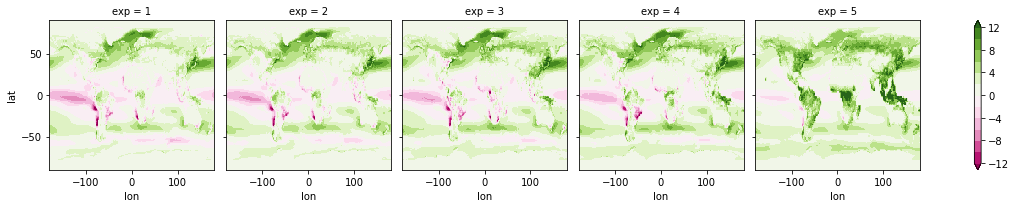

In [15]:
deltac[1:,:,:].mean(dim='model').plot(x='lon',y='lat',col='exp', levels=np.arange(-12,14,2), cmap='PiYG')

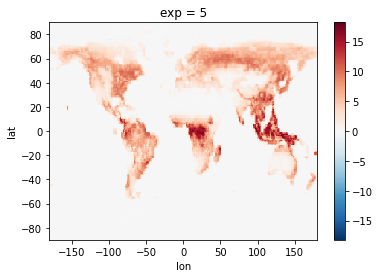

In [16]:
cland_delta[5,:,:].mean(dim='model').plot(x='lon',y='lat')

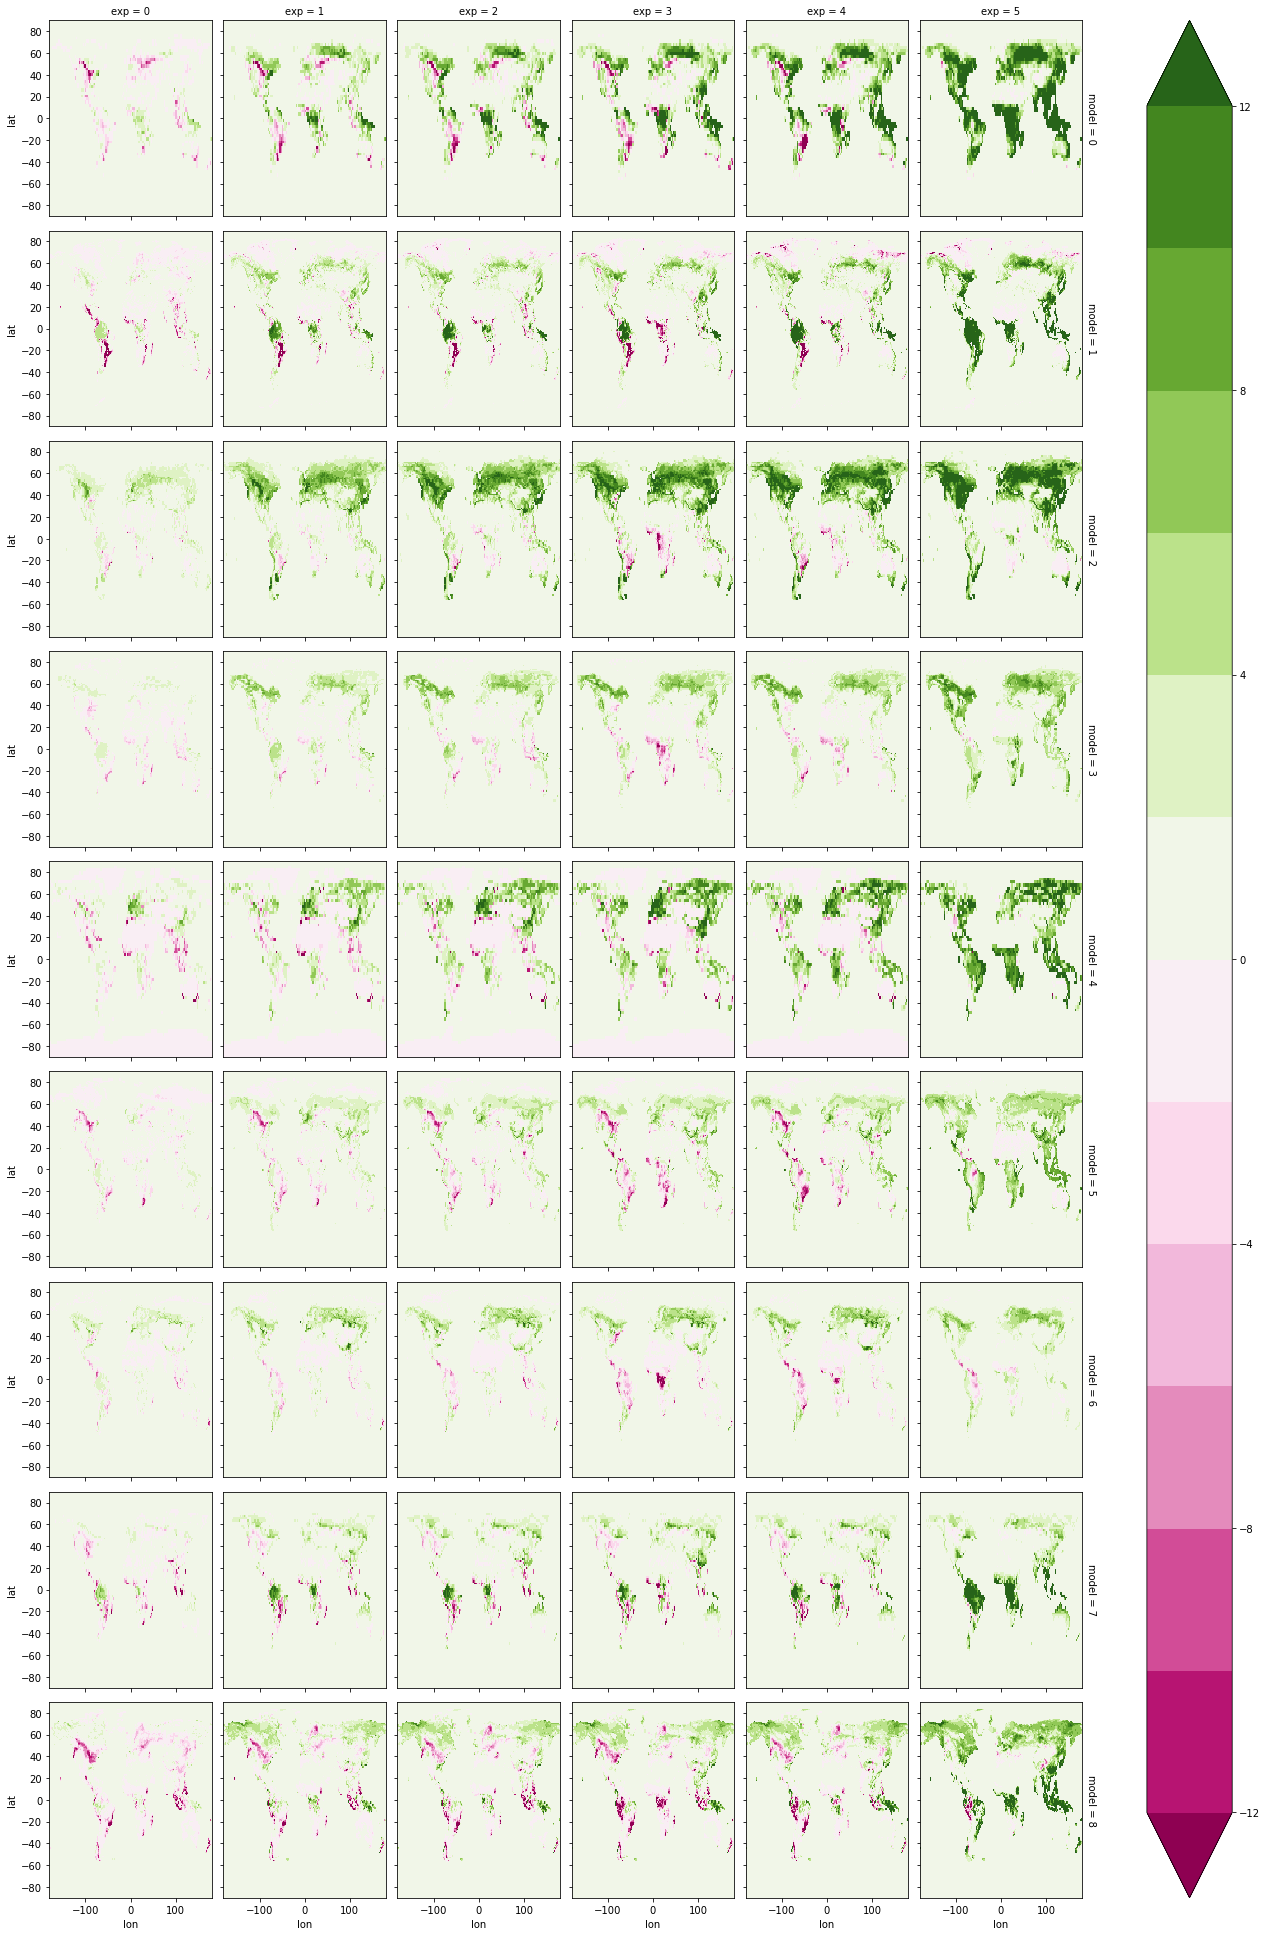

In [17]:
cland_delta.plot(x='lon',y='lat',col='exp', row='model', levels=np.arange(-12,14,2), cmap='PiYG')

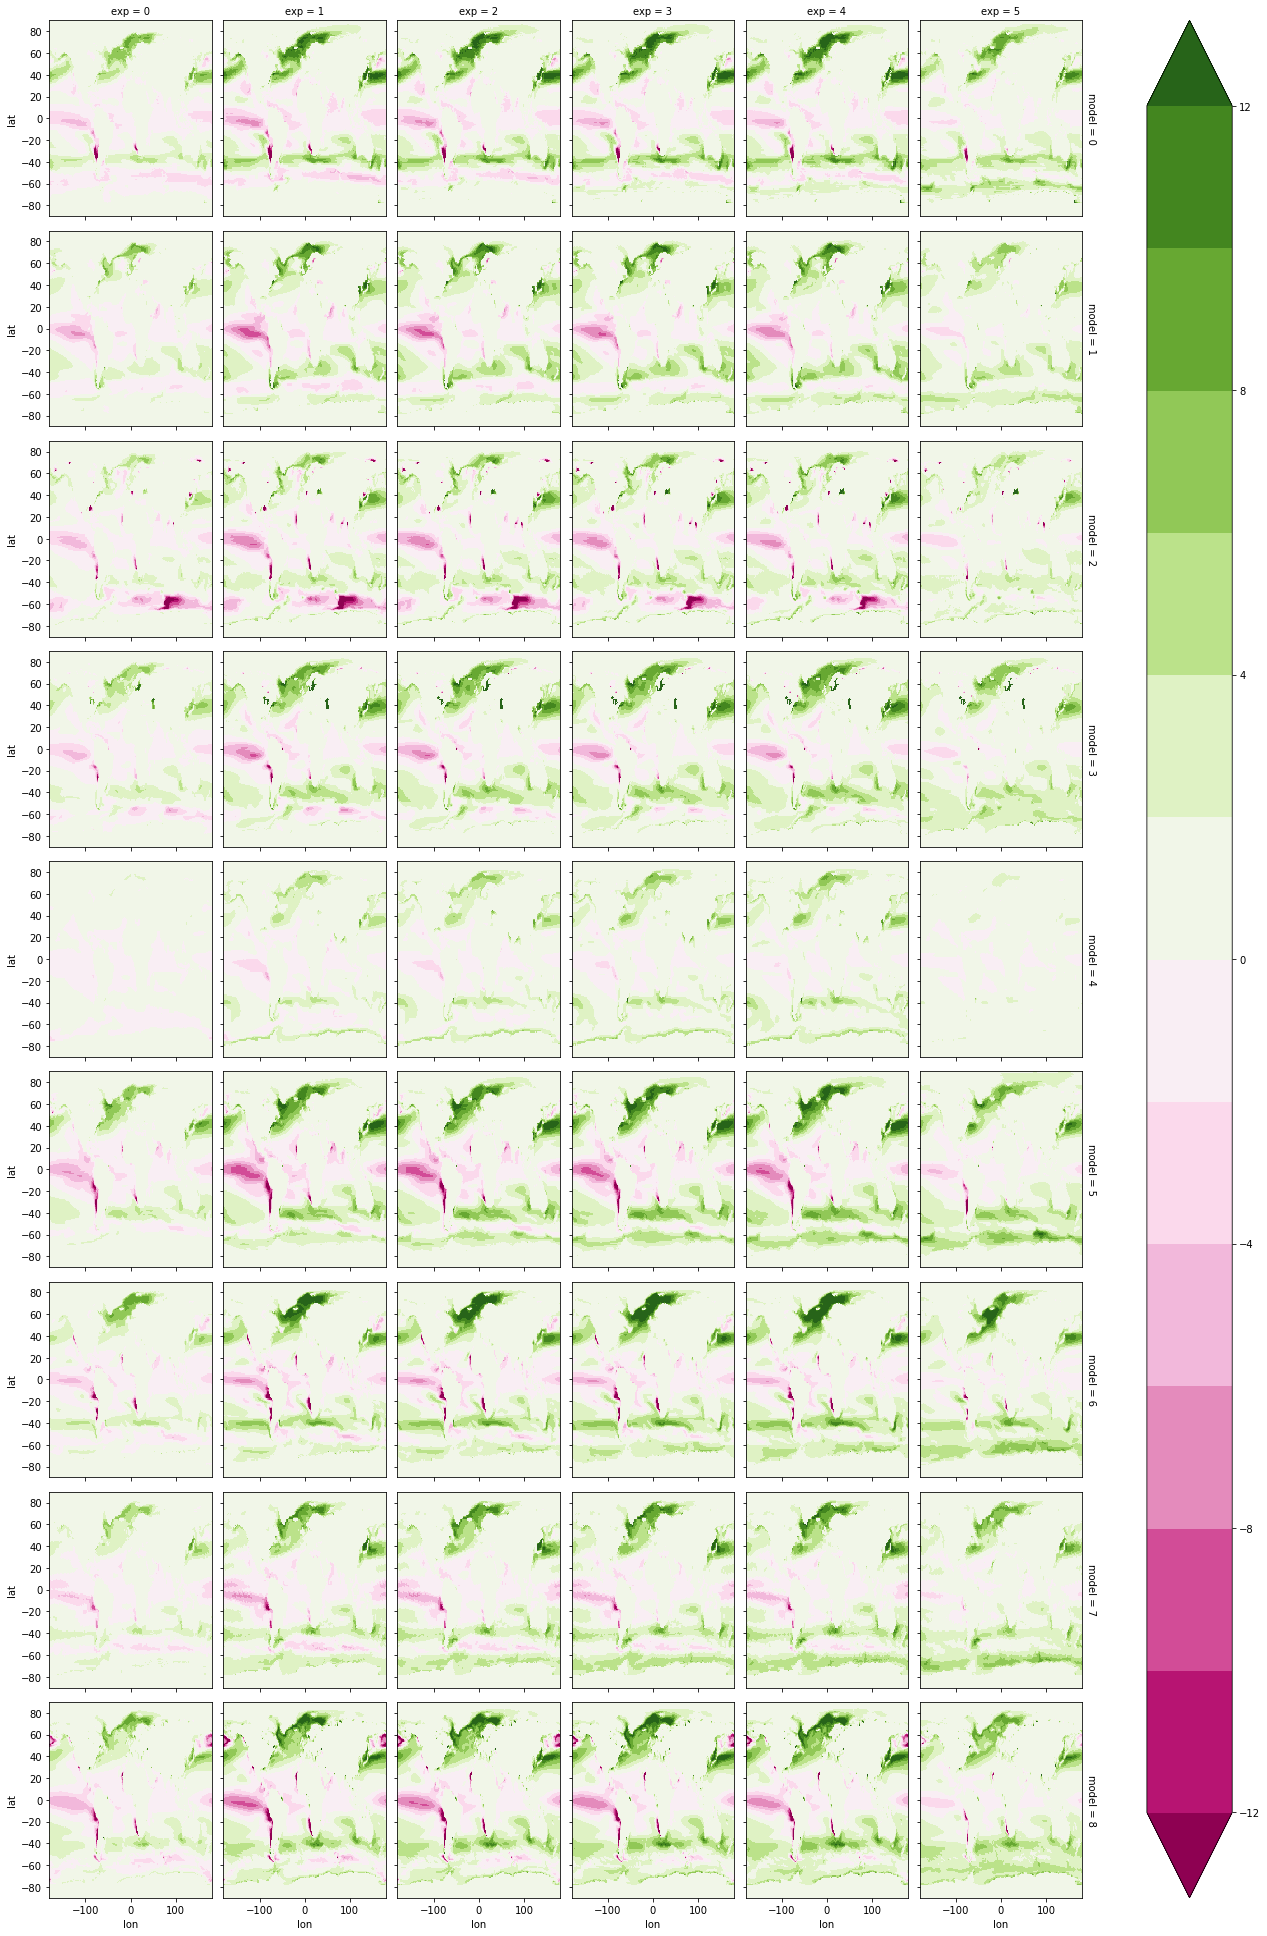

In [18]:
cOcn_delta.plot(x='lon',y='lat',col='exp', row='model', levels=np.arange(-12,14,2), cmap='PiYG')

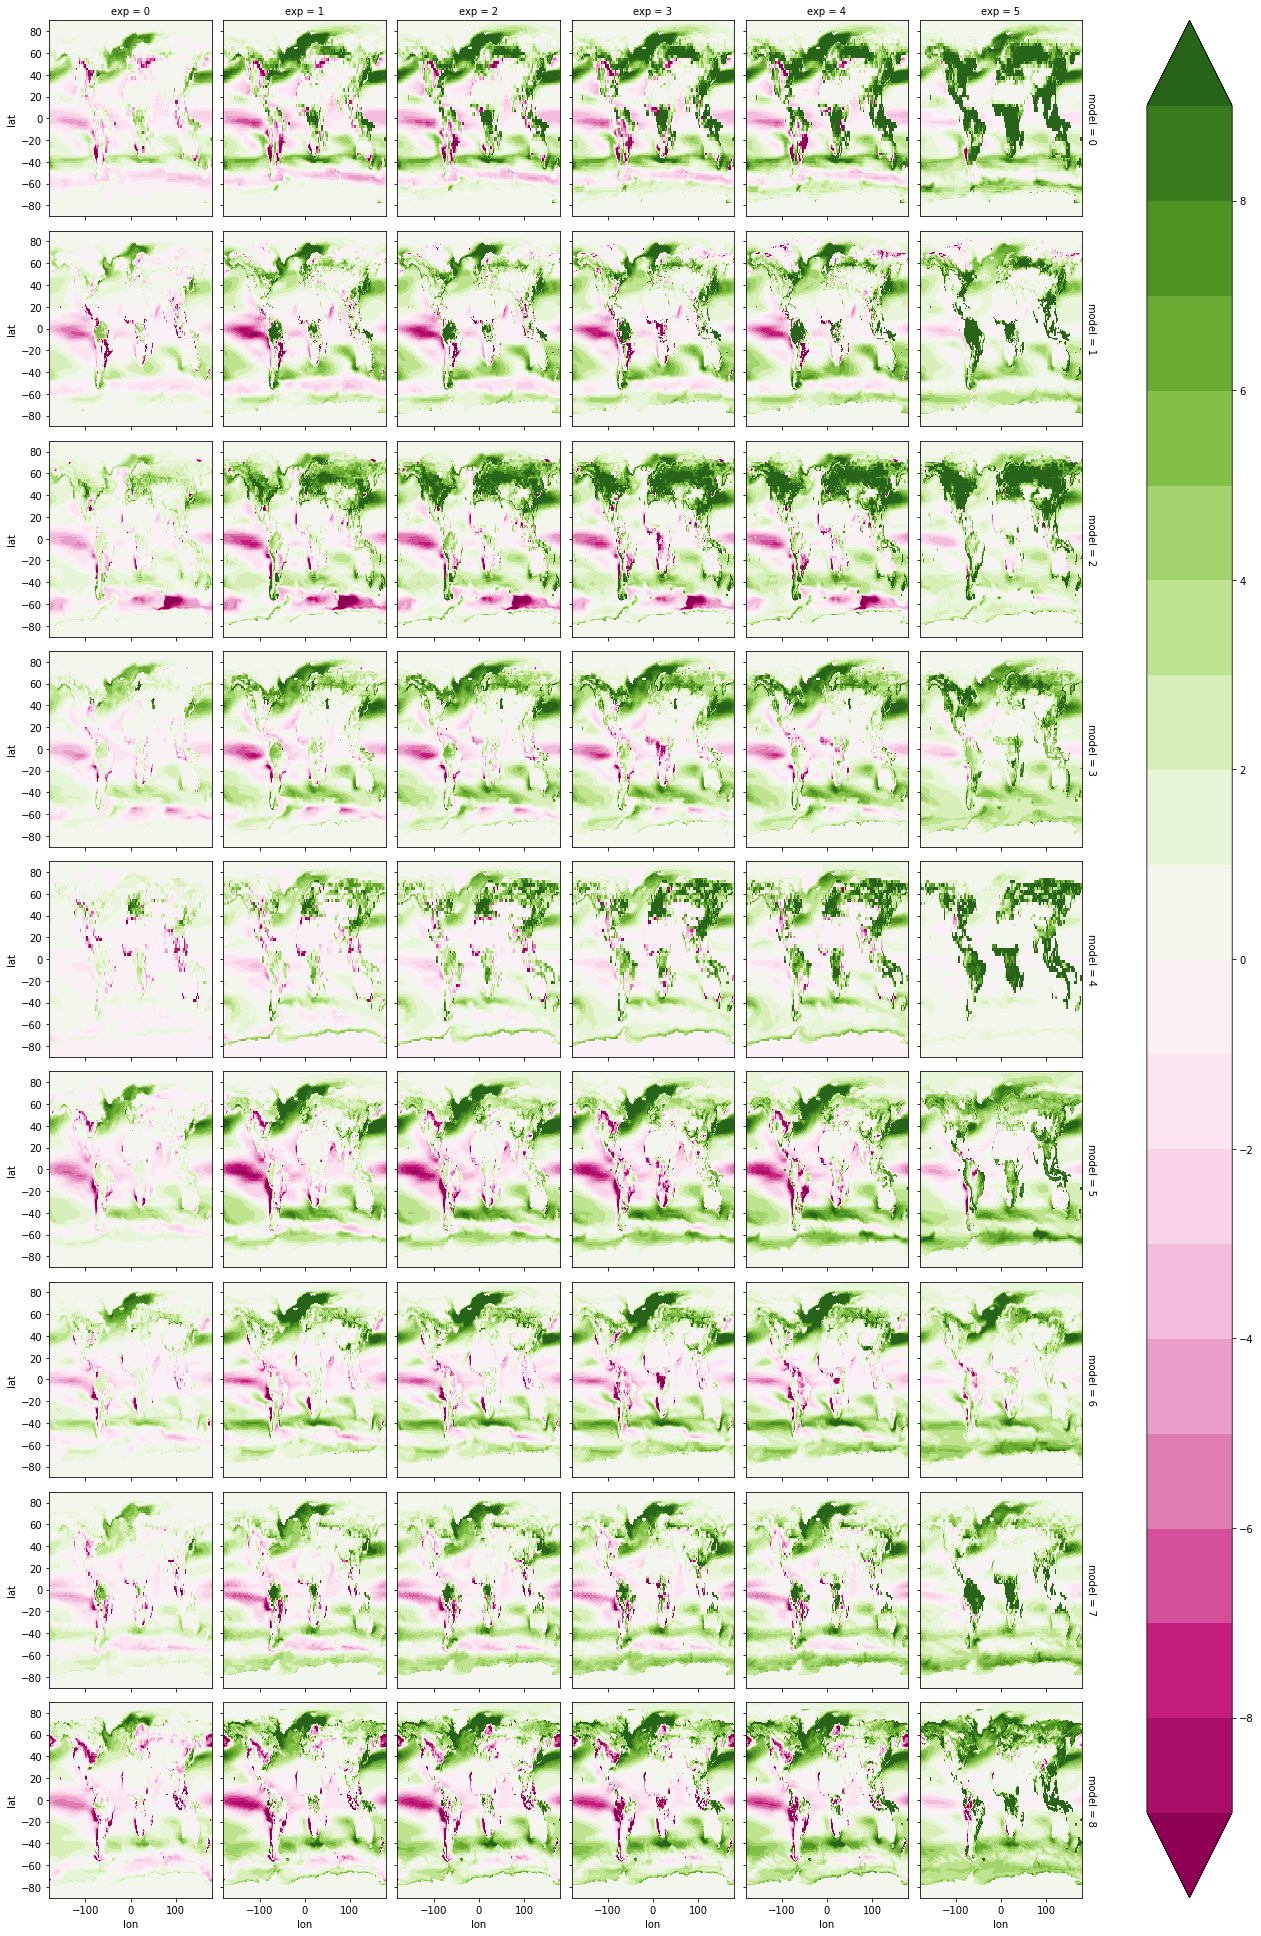

In [19]:
deltac.plot(x='lon',y='lat',col='exp', row='model', levels=np.arange(-9,10,1), cmap='PiYG')

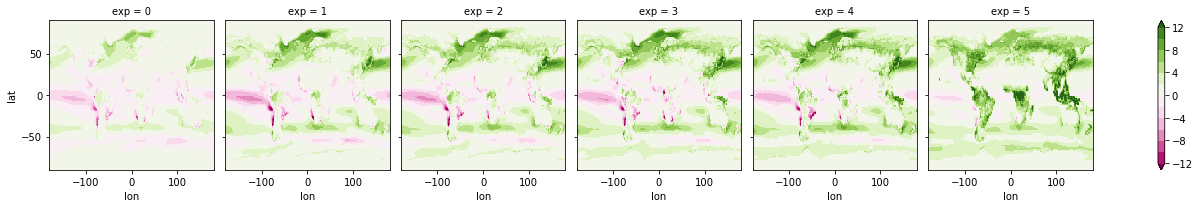

In [20]:
deltac.mean(dim='model').plot(x='lon',y='lat',col='exp', levels=np.arange(-12,14,2), cmap='PiYG')

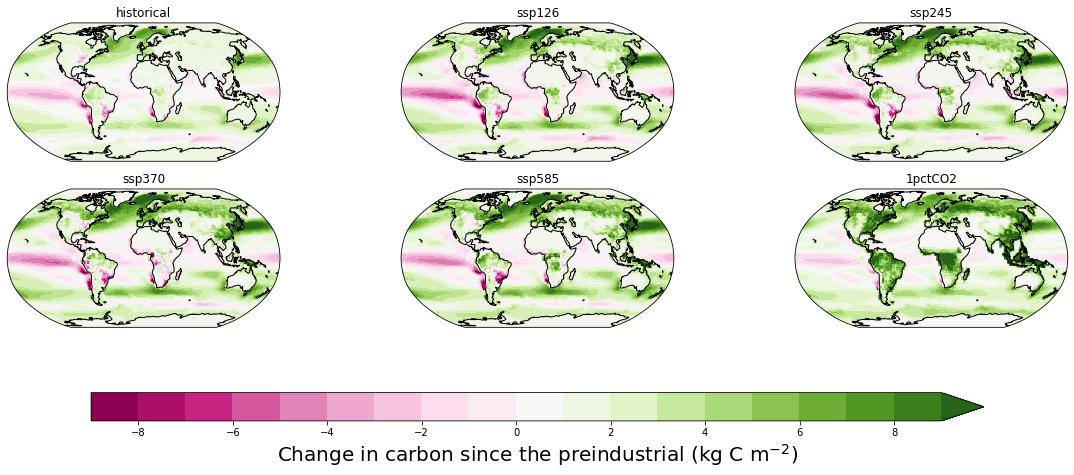

In [21]:
f, axislist = plt.subplots(nrows=2, ncols=3, figsize=(20, 8), subplot_kw={'projection': ccrs.Robinson()})

for i_exp in range(6):
    a = deltac[i_exp,:,:].mean(dim='model').plot(ax=axislist.flatten()[i_exp], transform=ccrs.PlateCarree(), add_colorbar=False, levels=np.arange(-9,10,1), cmap='PiYG')  # cmap='PRGn'
    axislist.flatten()[i_exp].coastlines()
    axislist.flatten()[i_exp].set_title(exps_list[i_exp])

cbar = f.colorbar(a, ax=axislist, orientation='horizontal', shrink=0.8, aspect=30)
cbar.set_label('Change in carbon since the preindustrial (kg C m$^{-2}$)', size=20)


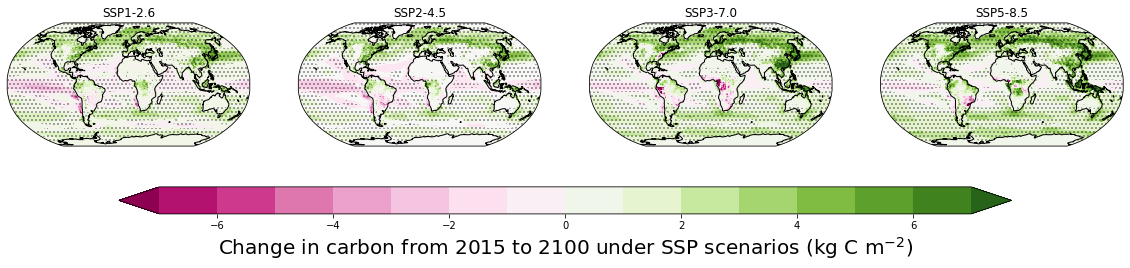

In [40]:
f, axislist = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), subplot_kw={'projection': ccrs.Robinson()})

titlelist = ['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5']
stipling_agreement_fraction = 0.80


for i_exp in range(1,5):
    i_plot = i_exp-1
    #
    # first calculate the change since 1850 
    deltac_since1850_ensmean = deltac[i_exp,:,:].mean(dim='model')-deltac[0,:,:].mean(dim='model')
    deltac_since1850_bymodel = deltac[i_exp,:,:]-deltac[0,:,:]
    fractional_agreement = (np.sign(deltac_since1850_bymodel) == np.sign(deltac_since1850_ensmean)).mean(dim='model')
    #
    a = deltac_since1850_ensmean.plot(ax=axislist.flatten()[i_plot], transform=ccrs.PlateCarree(), add_colorbar=False, levels=np.arange(-7,8,1.), cmap='PiYG')  # cmap='PRGn'
    axislist.flatten()[i_plot].coastlines()
    axislist.flatten()[i_plot].axes.contourf(fractional_agreement.lon,fractional_agreement.lat,1.-fractional_agreement,levels=[0.,1.-stipling_agreement_fraction],
             antialiased = False,
             extend ='neither',
             colors='white',
             hatches=['...'],
             transform=ccrs.PlateCarree(), alpha=0.0)
    axislist.flatten()[i_plot].set_title(titlelist[i_plot])

cbar = f.colorbar(a, ax=axislist, orientation='horizontal', shrink=0.8, aspect=30)
cbar.set_label('Change in carbon from 2015 to 2100 under SSP scenarios (kg C m$^{-2}$)', size=20)

f.savefig('delta_c_maps_ssps.png', dpi=300, format='png')
f.savefig('delta_c_maps_ssps.pdf', format='pdf')

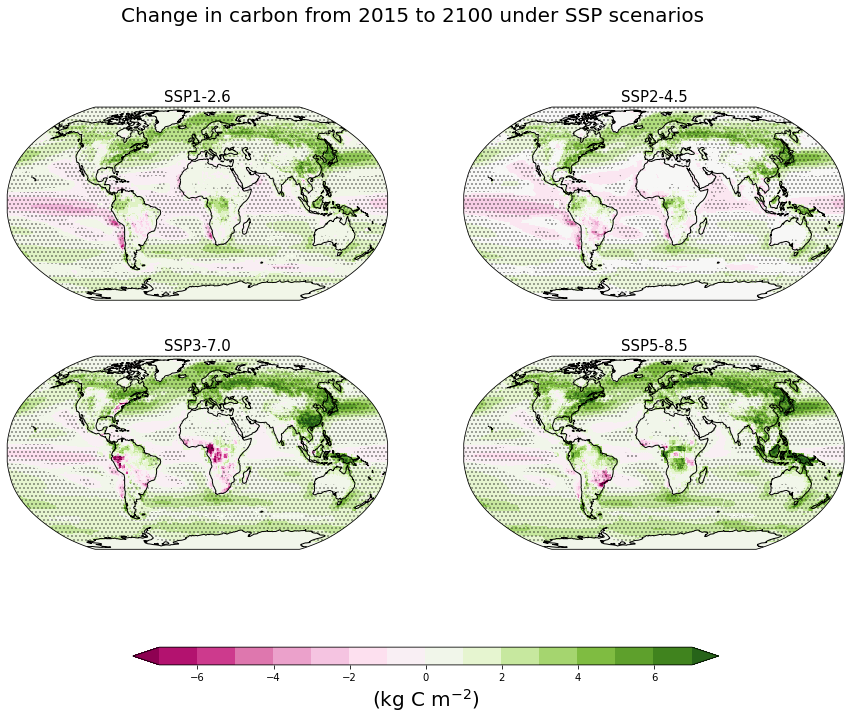

In [39]:
f, axislist = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), subplot_kw={'projection': ccrs.Robinson()})

titlelist = ['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5']
stipling_agreement_fraction = 0.80


for i_exp in range(1,5):
    i_plot = i_exp-1
    #
    # first calculate the change since 1850 
    deltac_since1850_ensmean = deltac[i_exp,:,:].mean(dim='model')-deltac[0,:,:].mean(dim='model')
    deltac_since1850_bymodel = deltac[i_exp,:,:]-deltac[0,:,:]
    fractional_agreement = (np.sign(deltac_since1850_bymodel) == np.sign(deltac_since1850_ensmean)).mean(dim='model')
    #
    a = deltac_since1850_ensmean.plot(ax=axislist.flatten()[i_plot], transform=ccrs.PlateCarree(), add_colorbar=False, levels=np.arange(-7,8,1.), cmap='PiYG')  # cmap='PRGn'
    axislist.flatten()[i_plot].coastlines()
    axislist.flatten()[i_plot].axes.contourf(fractional_agreement.lon,fractional_agreement.lat,1.-fractional_agreement,levels=[0.,1.-stipling_agreement_fraction],
             antialiased = False,
             extend ='neither',
             colors='white',
             hatches=['...'],
             transform=ccrs.PlateCarree(), alpha=0.0)
    axislist.flatten()[i_plot].set_title(titlelist[i_plot], size=15)

cbar = f.colorbar(a, ax=axislist, orientation='horizontal', shrink=0.7, aspect=30)
cbar.set_label('(kg C m$^{-2}$)', size=20)
f.suptitle('Change in carbon from 2015 to 2100 under SSP scenarios', size=20)
f.savefig('delta_c_maps_ssps_2x2.png', dpi=300, format='png')
f.savefig('delta_c_maps_ssps_2x2.pdf', format='pdf')

## 